In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 5)

# If notebook is inside notebooks/ this moves one level up to project root
BASE_DIR = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
RAW_PATH = BASE_DIR / "data" / "raw" / "nyc_311_sample.csv"

RAW_PATH, RAW_PATH.exists()

(PosixPath('/Users/yerapark/Documents/GitHub/nyc-311-service-analysis/data/raw/nyc_311_sample.csv'),
 True)

In [6]:
df = pd.read_csv(RAW_PATH)
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,descriptor_2,location_type,incident_zip,incident_address,...,resolution_action_updated_date,closed_date,taxi_pick_up_location,taxi_company_borough,facility_type,bridge_highway_name,bridge_highway_segment,road_ramp,due_date,bridge_highway_direction
0,67261544,2025-12-22T02:20:56.000,DSNY,Department of Sanitation,Street Sweeping Complaint,Street Not Swept,NaN,Street,10028.0,120 EAST 83 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67260416,2025-12-22T02:20:43.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,NaN,Residential Building/House,11234.0,1776 EAST 53 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67259338,2025-12-22T02:20:30.000,NYPD,New York City Police Department,Blocked Driveway,No Access,NaN,Street/Sidewalk,11204.0,7221 19 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67257438,2025-12-22T02:20:04.000,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,NaN,Residential Building/House,10473.0,2120 RANDALL AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67256419,2025-12-22T02:19:07.000,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,NaN,Residential Building/House,10002.0,166 SUFFOLK STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape, df.dtypes

((10000, 44),
 unique_key                          int64
 created_date                       object
 agency                             object
 agency_name                        object
 complaint_type                     object
 descriptor                         object
 descriptor_2                       object
 location_type                      object
 incident_zip                      float64
 incident_address                   object
 street_name                        object
 cross_street_1                     object
 cross_street_2                     object
 intersection_street_1              object
 intersection_street_2              object
 address_type                       object
 city                               object
 landmark                           object
 status                             object
 community_board                    object
 council_district                  float64
 police_precinct                    object
 bbl                               float

In [12]:
# Convert date columns to datetime; invalid entries become NaT
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce")

# Drop rows with missing/invalid dates
df = df.dropna(subset=["created_date", "closed_date"])

df[["created_date", "closed_date"]].head()

,created_date,closed_date
22,2025-12-22 02:04:57,2025-12-22 02:21:08
29,2025-12-22 02:00:56,2025-12-22 02:13:44
39,2025-12-22 01:54:08,2025-12-22 02:05:31
41,2025-12-22 01:53:17,2025-12-22 02:06:04
45,2025-12-22 01:52:16,2025-12-22 02:12:08


In [13]:
# Resolution time in hours
df["resolution_hours"] = (
    df["closed_date"] - df["created_date"]
).dt.total_seconds() / 3600

# Keep only non-negative and reasonable values (<= 30 days)
df = df[(df["resolution_hours"] >= 0) & (df["resolution_hours"] <= 24 * 30)]

df[["created_date", "closed_date", "resolution_hours"]].head()
df["resolution_hours"].describe()


/var/folders/4z/nymv3nx125bgkghtk67ltjvm0000gn/T/ipykernel_77215/3421622380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["resolution_hours"] = (


count    5504.000000
mean        2.412137
std         3.345039
min         0.000000
25%         0.509931
50%         1.169167
75%         2.717083
max        24.387778
Name: resolution_hours, dtype: float64

In [14]:
df["month"] = df["created_date"].dt.month
df["hour"] = df["created_date"].dt.hour
df["weekday"] = df["created_date"].dt.weekday  # 0 = Monday, 6 = Sunday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

df[[
    "complaint_type", "borough", "agency",
    "resolution_hours", "month", "hour", "weekday", "is_weekend"
]].head()


,complaint_type,borough,agency,resolution_hours,month,hour,weekday,is_weekend
22,Noise - Commercial,MANHATTAN,NYPD,0.269722,12,2,0,0
29,Noise - Residential,MANHATTAN,NYPD,0.213333,12,2,0,0
39,Noise - Residential,BROOKLYN,NYPD,0.189722,12,1,0,0
41,Abandoned Vehicle,QUEENS,NYPD,0.213056,12,1,0,0
45,Blocked Driveway,QUEENS,NYPD,0.331111,12,1,0,0


In [ ]:
complaint_counts = df["complaint_type"].value_counts().head(10)
complaint_counts

complaint_type
Illegal Parking            1781
Noise - Residential        1431
Blocked Driveway            655
Noise - Commercial          250
Noise - Street/Sidewalk     239
Noise - Vehicle             155
Abandoned Vehicle           135
HEAT/HOT WATER              135
Encampment                   80
Water System                 64
Name: count, dtype: int64

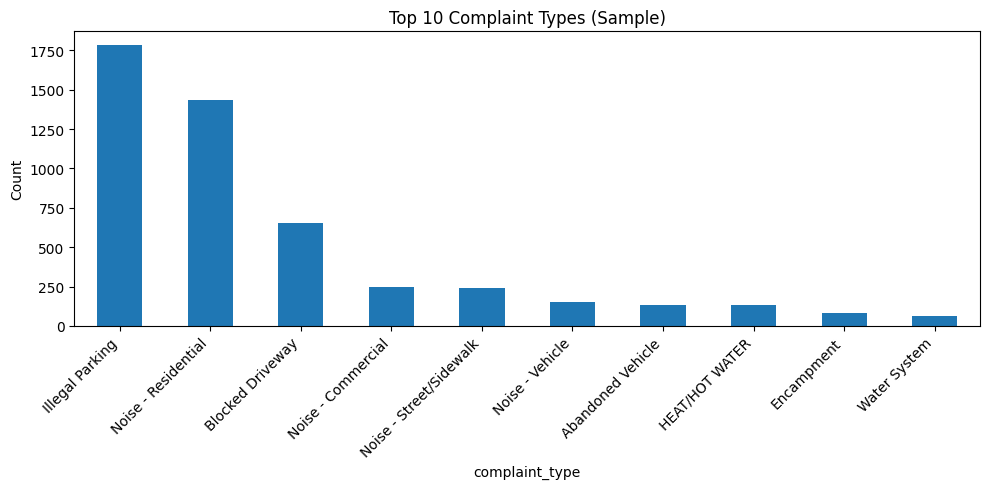

In [16]:
complaint_counts.plot(kind="bar")
plt.title("Top 10 Complaint Types (Sample)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

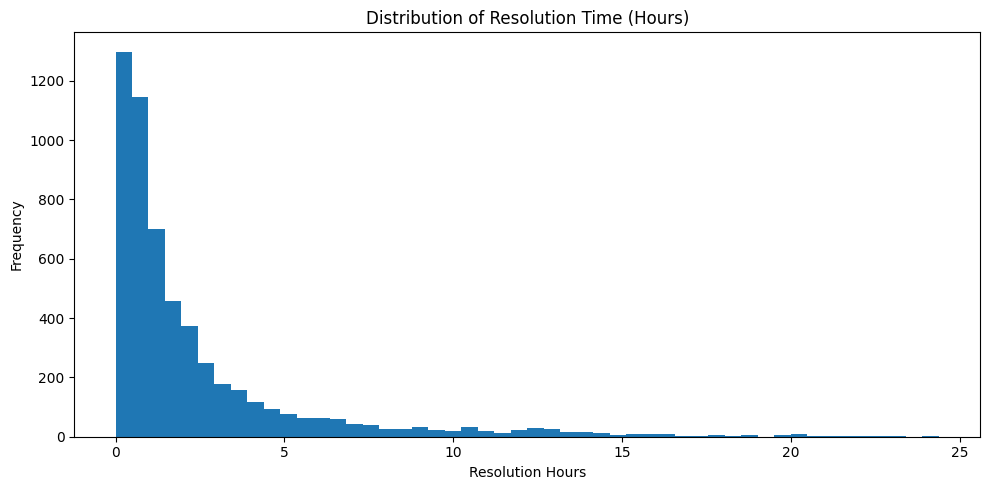

In [ ]:
# Visualize resolution time by hours
df["resolution_hours"].plot(kind="hist", bins=50)
plt.title("Distribution of Resolution Time (Hours)")
plt.xlabel("Resolution Hours")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [18]:
top10_types = df["complaint_type"].value_counts().head(10).index

avg_resolution_by_type = (
    df[df["complaint_type"].isin(top10_types)]
    .groupby("complaint_type")["resolution_hours"]
    .mean()
    .sort_values()
)

avg_resolution_by_type

complaint_type
Water System                0.857031
Noise - Vehicle             1.419871
Noise - Street/Sidewalk     1.706090
Encampment                  1.808753
Noise - Commercial          1.877472
Noise - Residential         2.227038
Illegal Parking             2.381552
Blocked Driveway            2.595982
Abandoned Vehicle           3.267726
HEAT/HOT WATER             10.176558
Name: resolution_hours, dtype: float64

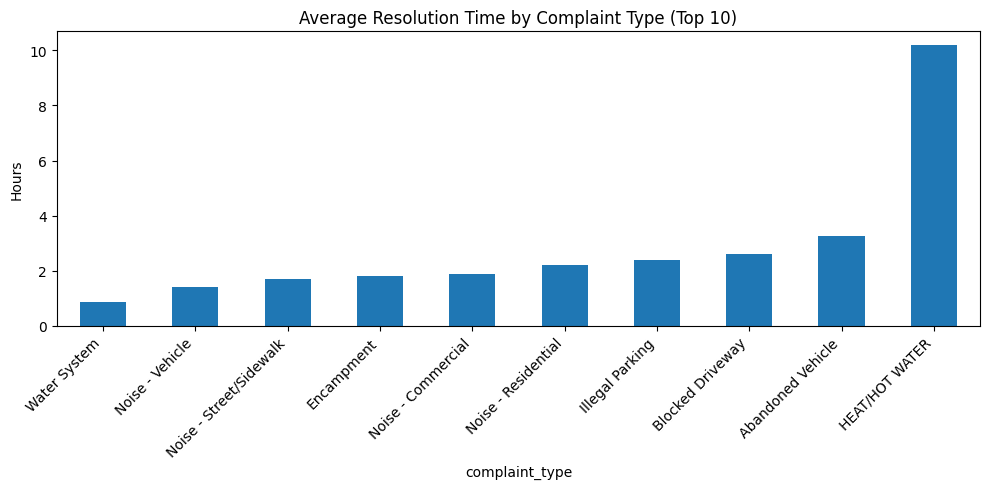

In [19]:
avg_resolution_by_type.plot(kind="bar")
plt.title("Average Resolution Time by Complaint Type (Top 10)")
plt.ylabel("Hours")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
CLEAN_DIR = BASE_DIR / "data" / "cleaned"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

clean_path = CLEAN_DIR / "nyc_311_sample_cleaned.parquet"
df.to_parquet(clean_path, index=False)

clean_path

PosixPath('/Users/yerapark/Documents/GitHub/nyc-311-service-analysis/data/cleaned/nyc_311_sample_cleaned.parquet')